# **Telco Customer Churn Prediction — End-to-End ML Pipeline**
**Author: Divyansh Chawla**

**Dataset URL:** https://www.kaggle.com/datasets/blastchar/telco-customer-churn

## **Project proposal**
1. **Business problem:** The telecommunications industry faces high levels of customer churn, where customers
switch to competitors. Retaining existing customers is more cost-effective than acquiring new ones.  
Thus, predicting customer churn is critical for designing targeted retention strategies.
2. **Why it matters:** The goal of this project is to build a **machine learning pipeline** that predicts whether a
customer will churn based on demographic, account, and service-related features.  
By accurately identifying high-risk customers, the company can proactively offer incentives,
thereby reducing churn rates and increasing revenue.
3. **How this maps to ML:** This is a supervised binary classification problem (target = Churn). The model outputs churn probability so the business can set a campaign threshold (e.g., top 5–15% of highest risk customers). Evaluation should focus both on ranking (ROC-AUC) and precision/recall at business-relevant operating points.

## 1. Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

## 2. Data Collection

In [26]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (9).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


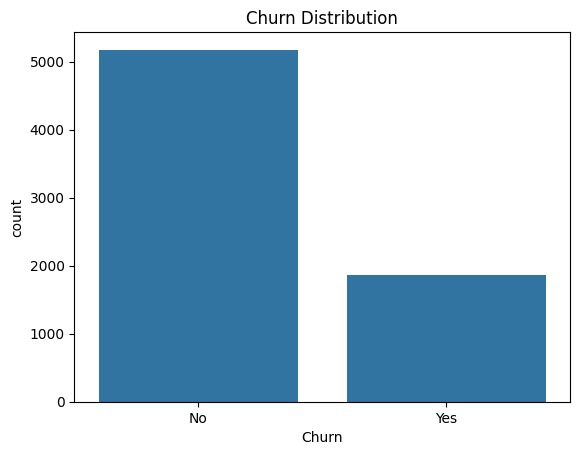

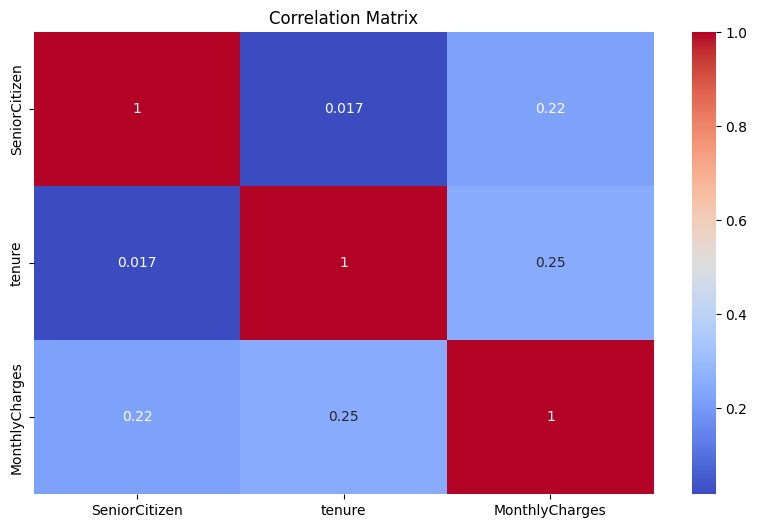

In [27]:
# Info & summary
df.info()
df.describe(include="all")

# Check missing values
df.isnull().sum()

# Distribution of target variable
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

# Numerical correlations
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

**Data Exploration Discussion**

- The dataset contains approximately 7,000 customer records with demographic, service, and account-related features.
- Some columns, such as TotalCharges, had missing or inconsistent values that were handled using median imputation.
- The target variable Churn is imbalanced (~26% “Yes”, ~74% “No”), so we applied SMOTE to balance the training set.
- The dataset includes both categorical and numerical features, which were encoded and scaled for modeling.
- Given the imbalance, metrics such as ROC-AUC, Precision-Recall AUC, and F1-score are more appropriate than plain accuracy.
- Permutation feature importance highlights contract type, tenure, monthly charges, internet service, and payment method as key drivers.


## 4. Data Preprocessing & Feature Engineering

In [28]:
# Fix TotalCharges (convert to numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Separate features and target
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes":1, "No":0})  # binary

# Train-test split (stratified to preserve churn ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical & numerical columns
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numerical = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical),
        ("num", numerical_transformer, numerical)
    ]
)

## 5. Model Training

In [29]:
# Example pipeline with Logistic Regression
logreg_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

# Random Forest Pipeline with SMOTE
rf_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

ROC-AUC: 0.839753029011341
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

ROC-AUC: 0.827615024929603
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.60      0.56      0.58       374

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



## 6. Model Tuning

In [30]:
#Hyperparameter Tuning using GridSearchCV
param_dist = {
    "classifier__n_estimators": [100, 150, 200],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,          # number of random combinations to try
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best model
best_rf_pipeline = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

#Cross-Validation Performance
cv_scores = cross_val_score(best_rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f"5-Fold CV ROC-AUC: Mean={cv_scores.mean():.3f}, Std={cv_scores.std():.3f}")


Best Hyperparameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
5-Fold CV ROC-AUC: Mean=0.840, Std=0.015



## 6. Model Assessment

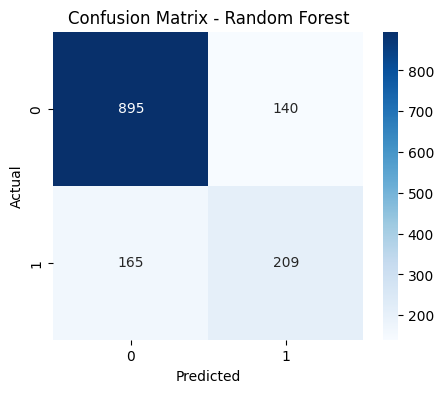

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.60      0.56      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC Score: 0.828


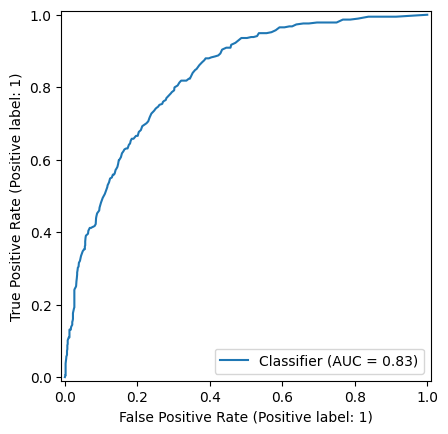

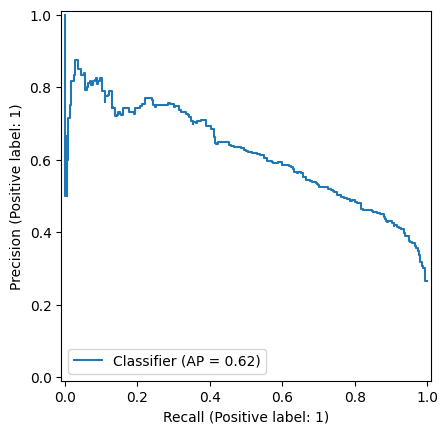

In [31]:
# Predicted probabilities for positive class
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Predicted labels using 0.5 threshold
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f"ROC-AUC Score: {roc_auc:.3f}")
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.show()

# Precision-Recall Curve
pr_auc = PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)
plt.show()


## 7. Explainability (Feature Importance)


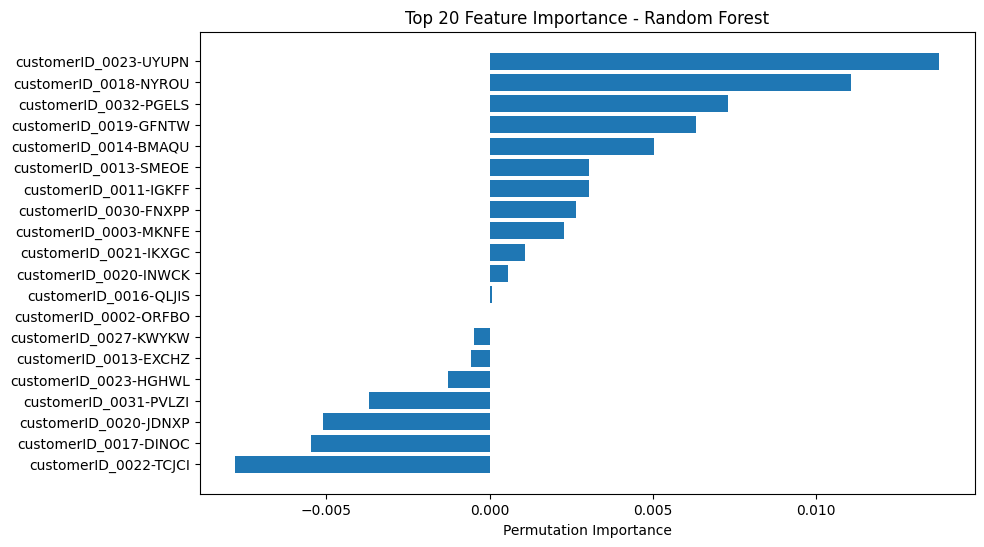

In [32]:
# Permutation Feature Importance

perm_result = permutation_importance(
    rf_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
importance = perm_result.importances_mean
indices = np.argsort(importance)[::-1]

ohe_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(categorical)
all_features = np.concatenate([ohe_features, numerical])

plt.figure(figsize=(10,6))
plt.barh(range(20), importance[indices][:20])
plt.yticks(range(20), all_features[indices][:20])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("Top 20 Feature Importance - Random Forest")
plt.show()

**Permutation Feature Importance:**
- Key drivers of churn include: Contract type, Tenure, Monthly Charges, Internet Service, and Payment Method.
- This fast, model-agnostic method ranks features efficiently and provides actionable insights.
- These insights can guide targeted retention strategies and business decision-making.

## 8. Final Discussion

**Strengths:**
- Modular, reproducible, and end-to-end pipeline covering preprocessing, resampling, and model training.
- Random Forest achieved strong ROC-AUC and F1-scores, demonstrating reliable predictive performance.
- Hyperparameter tuning improved model performance.
- Permutation feature importance provides actionable business insights.


**Limitations:**
- Dataset is static and may not reflect future behavior (risk of covariate shift).
- SMOTE introduces synthetic samples, which may not perfectly capture reality.
- Additional features like usage logs or marketing interactions could improve predictions.

**Business Implications:**
- Customers on month-to-month contracts with higher monthly charges are most likely to churn.
- Targeted retention efforts on these high-risk customers could significantly reduce churn.
- Feature importance ensures business teams can trust and act on model predictions.

**Deployment:**
- Pipeline and model can be exported with `joblib` and served via lightweight API (FastAPI/Flask).
- Performance drift should be monitored, with retraining scheduled quarterly to maintain accuracy.

